<a href="https://colab.research.google.com/github/Whitchurch/CNNTensorflowCode/blob/main/Team17_CNN_RMSE_Timetracking_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow-GPU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the required libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv 
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.models import Sequential
from keras import backend # I am importing this to inherit and create an RMSE metric later in my code.
#from keras.layers import CuDNNLSTM # A superior LSTM that uses GPU more optimized for training. (CUDNNLSTM currently not working in Google Colab#)

# Load and read data:

In [4]:
os.chdir("drive/My Drive/Colab Notebooks")


In [5]:
#Read the clean signal
with open('ECGsignal2700.csv') as csv_file:
  csv_reader = csv.reader(csv_file)

  for ECGsignal in csv_reader:
     print(ECGsignal)
  print("Finished reading the file")

#Time to dissect the file read data's anatomy:
#Total number of items in the list:
len(ECGsignal)

#Convert the list to an array 
ECGsignal_arr = np.array(ECGsignal,dtype=float)

#Read the noisy signal
with open('ECGsignal_n2700.csv') as csv_file:
  csv_reader = csv.reader(csv_file)

  for ECGsignal_n in csv_reader:
     print(ECGsignal_n)
  print("Finished reading the file")

#Time to dissect the file read data's anatomy:
#Total number of items in the list:
len(ECGsignal_n)

#Convert the list to an array 
ECGsignal_n_arr = np.array(ECGsignal_n,dtype=float)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Reshape the data + Split data into test and training sets

In [6]:
tupleofdimensions = ECGsignal_arr.shape
num = tupleofdimensions[0]
Training_test_Split = 0.75  # Modify this line to control the Test-Train split

a=Training_test_Split*num;                                 
XTrain=ECGsignal_n_arr[0:int(a)];                  
YTrain=ECGsignal_arr[0:int(a)];
XTest=ECGsignal_n_arr[int(a):num];               
YTest=ECGsignal_arr[int(a):num];
scaling_factor = num/(5400000)
train_samples=(30*60*Training_test_Split/10)*scaling_factor;
test_samples =(30*60*(1-Training_test_Split)/10)*scaling_factor;

print(XTrain.shape)
print(XTest.shape)
print(int(train_samples))
print(int(test_samples))

(20250000,)
(6750000,)
675
225


In [7]:
print(YTrain.shape)
print(YTest.shape)

(20250000,)
(6750000,)


# Change data from 1D to 4D

Reference:https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca

In [8]:
XTrain_reshaped = np.reshape(XTrain,(int(train_samples),30000,1,1))
YTrain_reshaped = np.reshape(YTrain,(int(train_samples),30000))

XTest_reshaped = np.reshape(XTest,(int(test_samples),30000,1,1))
YTest_reshaped = np.reshape(YTest,(int(test_samples),30000))

print(XTest_reshaped.shape)
print(XTrain_reshaped.shape)





(225, 30000, 1, 1)
(675, 30000, 1, 1)


# Define Callbacks to output Training times

In [9]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

mycallbacks = TimeHistory() 

# Define Custom RMSE metric. Overriding default Keras MSE metric

In [10]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Define the layers of the CNN - From the De-noising paper

In [11]:
model = Sequential(name="DNN_using_CNN_for_Denoising")

# Convolution layers are used to extract the most prominent features of the input data.
#Layer 1:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36, (19,1), input_shape=(30000,1,1),activation='relu',padding='SAME',strides=(1,1),name='conv_1')) 
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Dense(units=36,activation='relu',name='relu_1'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_1'))

#Layer 2:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_2'))
model.add(BatchNormalization(name='batchnorm_2'))
model.add(Dense(units=36,activation='relu',name='relu_2'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_2'))

#Layer 3:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_3'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Dense(units=36,activation='relu',name='relu_3'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_3'))

#Layer 4:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_4'))
model.add(BatchNormalization(name='batchnorm_4'))
model.add(Dense(units=36,activation='relu',name='relu_4'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_4'))


#Layer 5:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_5'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Dense(units=36,activation='relu',name='relu_5'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_5'))


#Layer 6:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_6'))
model.add(BatchNormalization(name='batchnorm_6'))
model.add(Dense(units=36,activation='relu',name='relu_6'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_6'))
model.add(Flatten())

#Now adding in the fully-connected dense layer: This will act on the data extracted from the CNN in the prior stages
model.add(Dense(units= 30000,activation=None,use_bias=True))
model.summary()

#Last layer of the FCN is only showing the inputsx weight.  
#Investigating to see, if the bias is used. even though model summary is not displaying it.
#weights, biases = model.layers[25].get_weights()
#print(len(weights))
#print(len(biases))

#Build the model, we follow the paper, using Adam optimizer, for speeding up gradient descent
#And RMS as the cost function, metric to optimize against.

#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse',rmse])

#Fit the model.
# Train the Model
#history = model.fit_generator(train_generator,validation_data = validation_generator, epochs = 10,steps_per_epoch = 1372, validation_steps = 350,verbose = 1 )
history = model.fit(XTrain_reshaped,YTrain_reshaped,epochs=280,verbose=2,validation_data=(XTest_reshaped,YTest_reshaped))

                                    

Model: "DNN_using_CNN_for_Denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30000, 1, 36)      720       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 30000, 1, 36)     144       
 tion)                                                           
                                                                 
 relu_1 (Dense)              (None, 30000, 1, 36)      1332      
                                                                 
 avgpool_1 (AveragePooling2D  (None, 7500, 1, 36)      0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 7500, 1, 36)       24660     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 75

# View all index Keys in the History Dictionary: Storing training metrics

In [12]:
#List all keys in History object
print(history.history.keys())

dict_keys(['loss', 'mse', 'rmse', 'val_loss', 'val_mse', 'val_rmse'])


# Plot: Training MSE vs Validation MSE

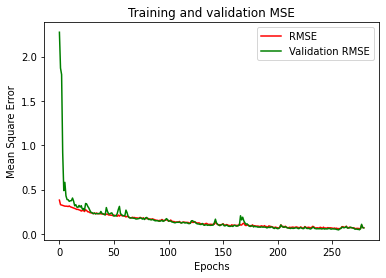

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
mse = history.history['loss']
val_mse = history.history['val_loss']
rmse = history.history['rmse']
val_rmse = history.history['val_rmse']


epochs = range(len(mse))

plt.plot(epochs, rmse, 'r', label='RMSE')
plt.plot(epochs, val_rmse, 'g', label='Validation RMSE')
plt.title('Training and validation MSE')
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

# Save trained model weights

In [14]:
#Save the model trained for 40 epochs.
model.save('CNN_40_Epochs_v1.model')

INFO:tensorflow:Assets written to: CNN_40_Epochs_v1.model/assets


# CHARTS:

**Expected**: ECG PLOT

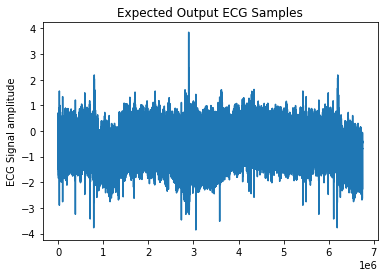

In [15]:
#Plot few samples of the output Test data:
plt.plot(YTest)
plt.title('Expected Output ECG Samples')
plt.ylabel('ECG Signal amplitude')
plt.show()


**Input:**  NOISY ECG PLOT:

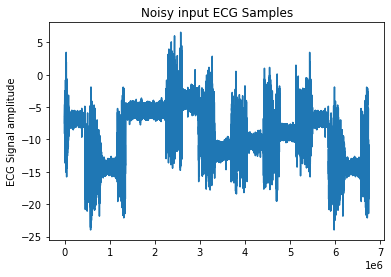

In [16]:
#Plot few samples of the input Test data:
plt.plot(XTest)
plt.title('Noisy input ECG Samples')
plt.ylabel('ECG Signal amplitude')
plt.show()

CNN DENOISED ECG SIGNAL PLOT:

In [17]:
#Do a prediction on the test data
prediction = model.predict(XTest_reshaped)
#print(prediction)

OUTPUT RESULT without reshaping:

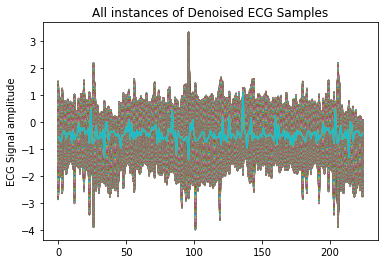

In [18]:
#Plot the denoised signal from the CNN
plt.plot(prediction)
plt.title('All instances of Denoised ECG Samples')
plt.ylabel('ECG Signal amplitude')
plt.show()

**RESHAPE and Then OUTPUT SIGNAL:**

(225, 30000)


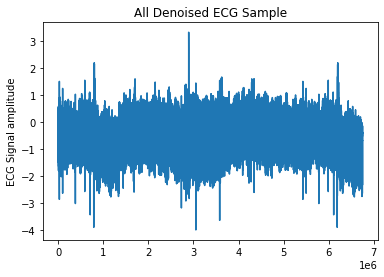

In [19]:
print(prediction.shape)
prediction_reshaped = np.reshape(prediction,XTest.shape)
#print(prediction_reshaped.shape)

#Plot the reshaped output signal from the CNN
plt.plot(prediction_reshaped)
plt.title('All Denoised ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

**Test :**  **Output for a single signal**

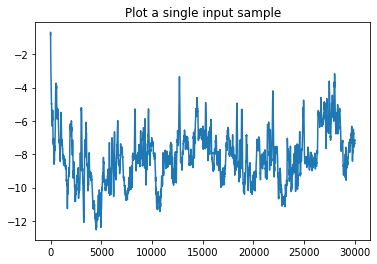

In [41]:
Xtest_1_Sample = XTest[60000:90000]
plt.plot(Xtest_1_Sample)
plt.title('Plot a single input sample')
plt.show()

**Test : Expected output sample**

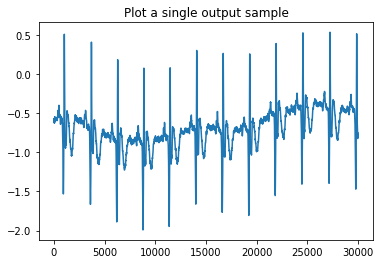

In [42]:
Ytest_1_Sample = YTest[60000:90000]
plt.plot(Ytest_1_Sample)
plt.title('Plot a single output sample')
plt.show()

**Test : Denoised output sample**

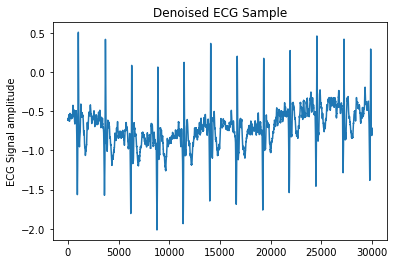

In [43]:
Xtest_1_Predicted = prediction_reshaped[60000:90000]
plt.plot(Xtest_1_Predicted)
plt.title('Denoised ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

**OVERLAY** :  **ORIGINAL ECG** over **DENOISED ECG** 

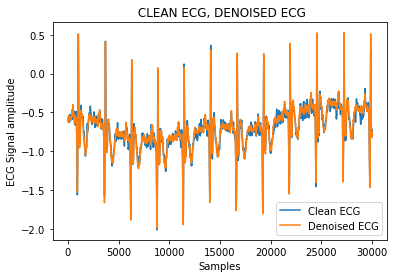

In [44]:
plt.title(' CLEAN ECG, DENOISED ECG')
plt.ylabel('ECG Signal amplitude')
plt.xlabel('Samples')

#DENOISED ECG
plt.plot(Xtest_1_Predicted)

#Clean ECG
plt.plot(Ytest_1_Sample)


plt.legend(['Clean ECG','Denoised ECG'])
plt.show()

# RMSE Score:

In [45]:
tf.print(backend.sqrt(backend.mean(backend.square(Ytest_1_Sample - Xtest_1_Predicted), axis=-1)))

0.052335677073342711


**RESULT:**
- We can clearly see that:  
- Denoised ECG and Clean ECG, closely follow each other.

**Helpful references:**

1)This explains why last dense layer has no activation function:
  - we primarily do that if we are trying to accuractely do regression.

https://stats.stackexchange.com/questions/361066/what-is-the-point-of-having-a-dense-layer-in-a-neural-network-with-no-activation

2)This video shows how to implement a stacked LSTM model:
https://www.youtube.com/watch?v=BSpXCRTOLJA

3) This video shows the inner anatomy of an LSTM, primarily the sigmoid and Tanh, used for gating inside the LSTM:
https://www.youtube.com/watch?v=8HyCNIVRbSU&t=632s

4) The blogpost that references the video in 3. Is linked here:
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

5) This is the link from Andrew NG, I studied to understand, why we use BatchNormalization in the CNN:
https://www.youtube.com/watch?v=nUUqwaxLnWs

6) Running on CPU vs GPU vs TPU???
https://serverguy.com/comparison/cpu-vs-gpu-vs-tpu/

7)https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

8)https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


